# IGRINS spot check with `muler` and `gollum`

Let's spot-check our data with muler and gollum!

In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList
from gollum.phoenix import PHOENIXGrid
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from tqdm.notebook import tqdm

In [4]:
fns = glob.glob('../../data/IGRINS/GS-2021A-Q-311/**/SDCH*.spec_a0v.fits', recursive=True)

In [5]:
len(fns)

24

### Map filenames to object

In [6]:
fn = fns[0]

In [7]:
lookup_dict={}
for fn in tqdm(fns):
    spec = IGRINSSpectrum(file=fn)
    lookup_dict[fn]=spec.meta['header']['OBJECT']
    del spec

  0%|          | 0/24 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame.from_dict(lookup_dict,orient='index').reset_index()
df = df.rename(columns={0:'Object', 'index':'fn'})[['Object', 'fn']]

In [9]:
df.Object.value_counts()

UCAC2 7201471              5
HD 49855                   5
TYC 8534-1243-1            5
V* V479 Car                5
V* V1249 Cen               2
2MASS J12271665-6239142    1
CD-62 657                  1
Name: Object, dtype: int64

Yay, we have up to 5 spectra on several of our targets.

In [10]:
target = 'V* V479 Car'

In [11]:
mask = df.Object == target

In [12]:
fns = sorted(df[mask].fn.values)

### Read in each spectrum 
... to an HPFSpectrumList Object

In [13]:
m = 13

In [14]:
spectra = []
for fn in tqdm(fns):
    spectra.append(IGRINSSpectrum(file=fn, order=m))

  0%|          | 0/5 [00:00<?, ?it/s]

Let's pick one representative spectra order and make a list of those spectra.

In [15]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


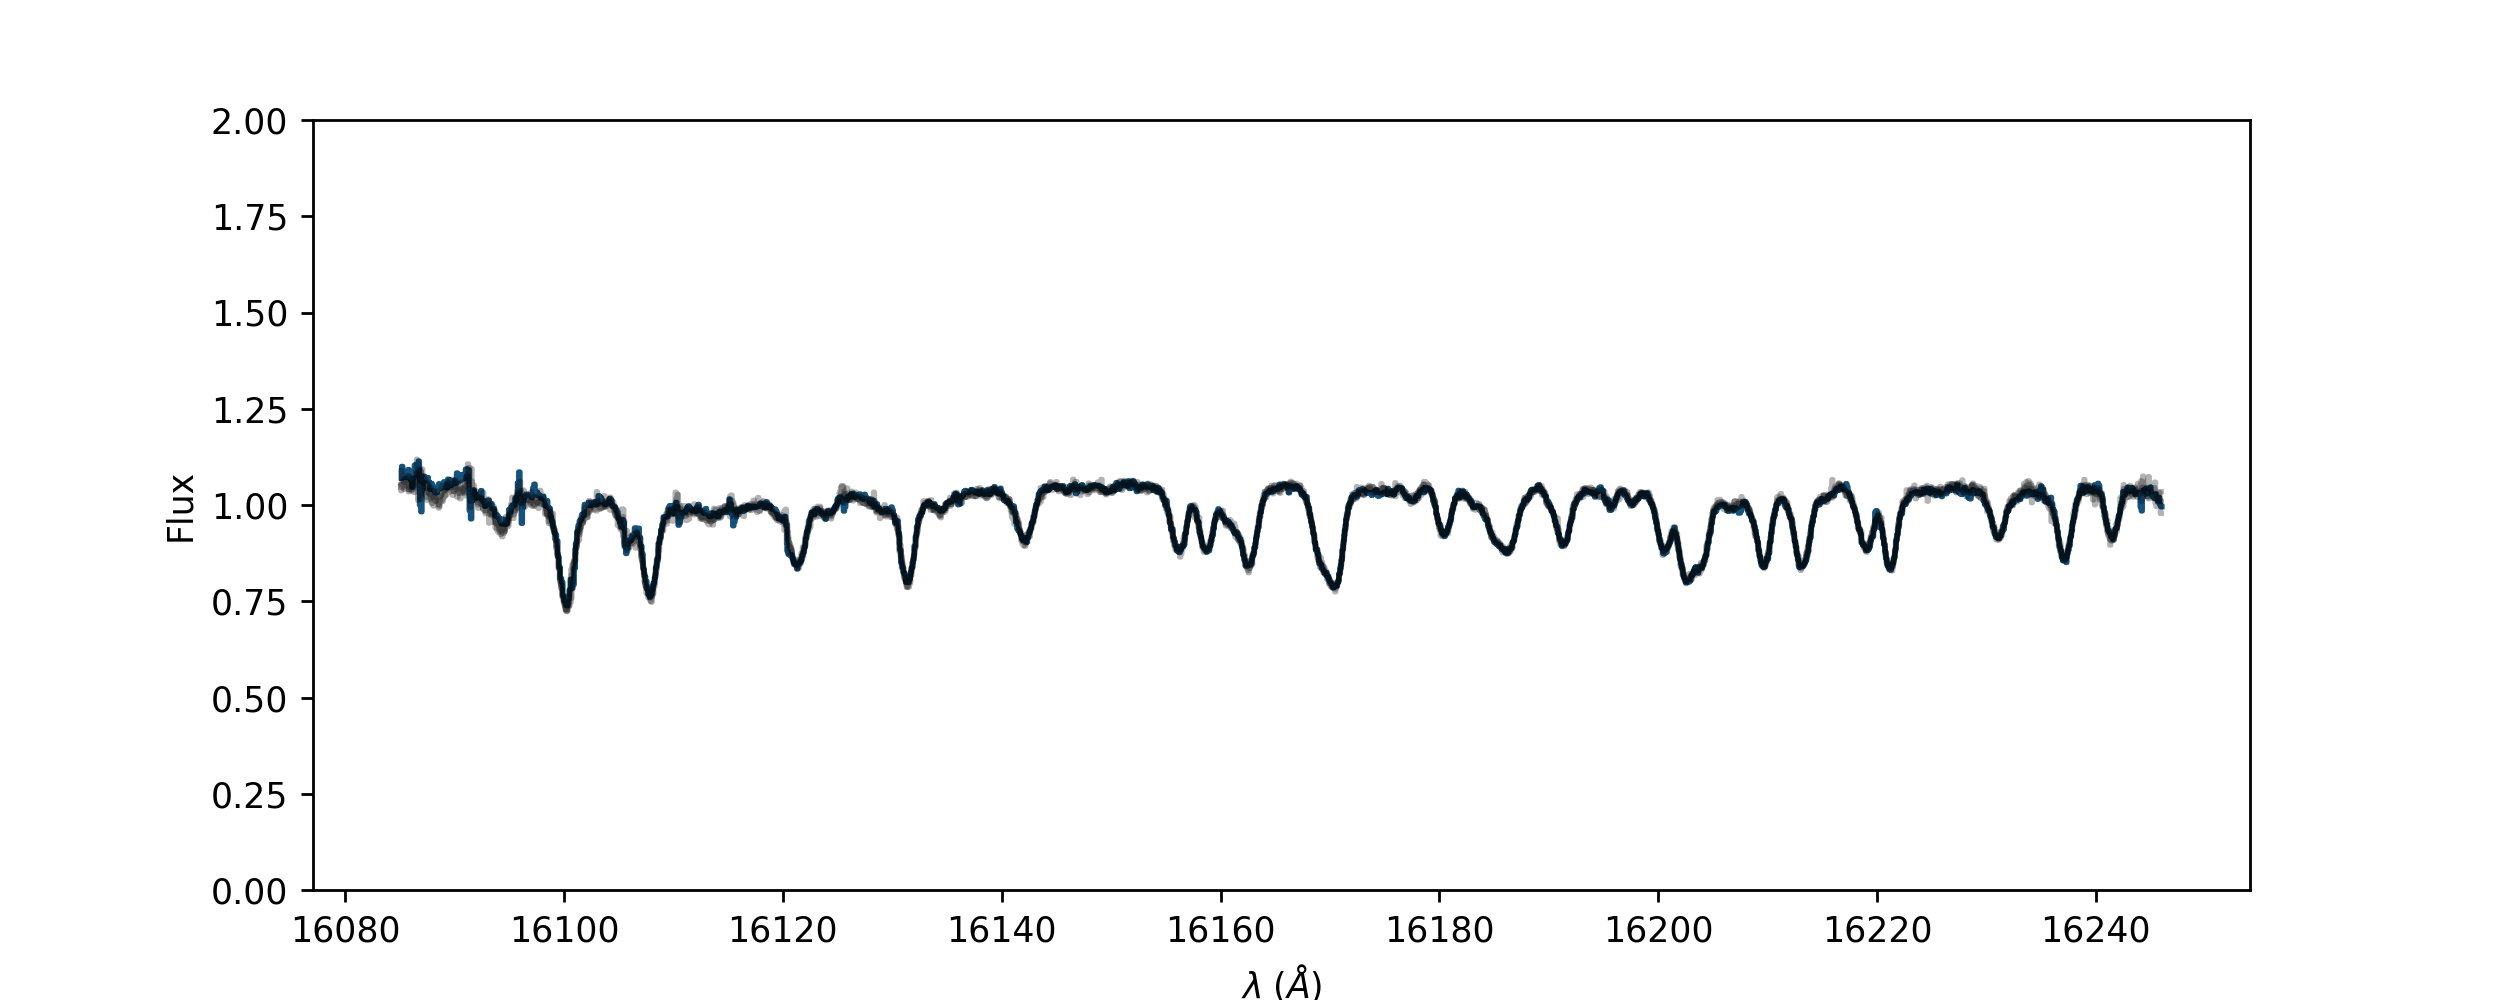

In [16]:
ax = spectra[0].trim_edges().normalize().barycentric_correct().plot(ylo=0, yhi=2)
for spectrum in spectra:
    spec = spectrum.trim_edges().normalize().barycentric_correct()
    ax.step(spec.wavelength, spec.flux, color='k', alpha=0.3)

In [17]:
from gollum.telluric import TelluricSpectrum
import astropy.units as u

In [18]:
for spectrum in spectra:
    print(spectrum.estimate_barycorr().to(u.km/u.s))

4.243419232774147 km / s
3.418409973690254 km / s
3.4294264167559434 km / s
2.862992019284707 km / s
2.744121926462109 km / s


In [19]:
data = spectrum.trim_edges().barycentric_correct().normalize()

wl_lo, wl_hi = data.wavelength.value.min(), data.wavelength.value.max()

In [20]:
tell_spec = TelluricSpectrum(
                    path="default", wl_lo=wl_lo, wl_hi=wl_hi
                )

<IPython.core.display.Javascript object>


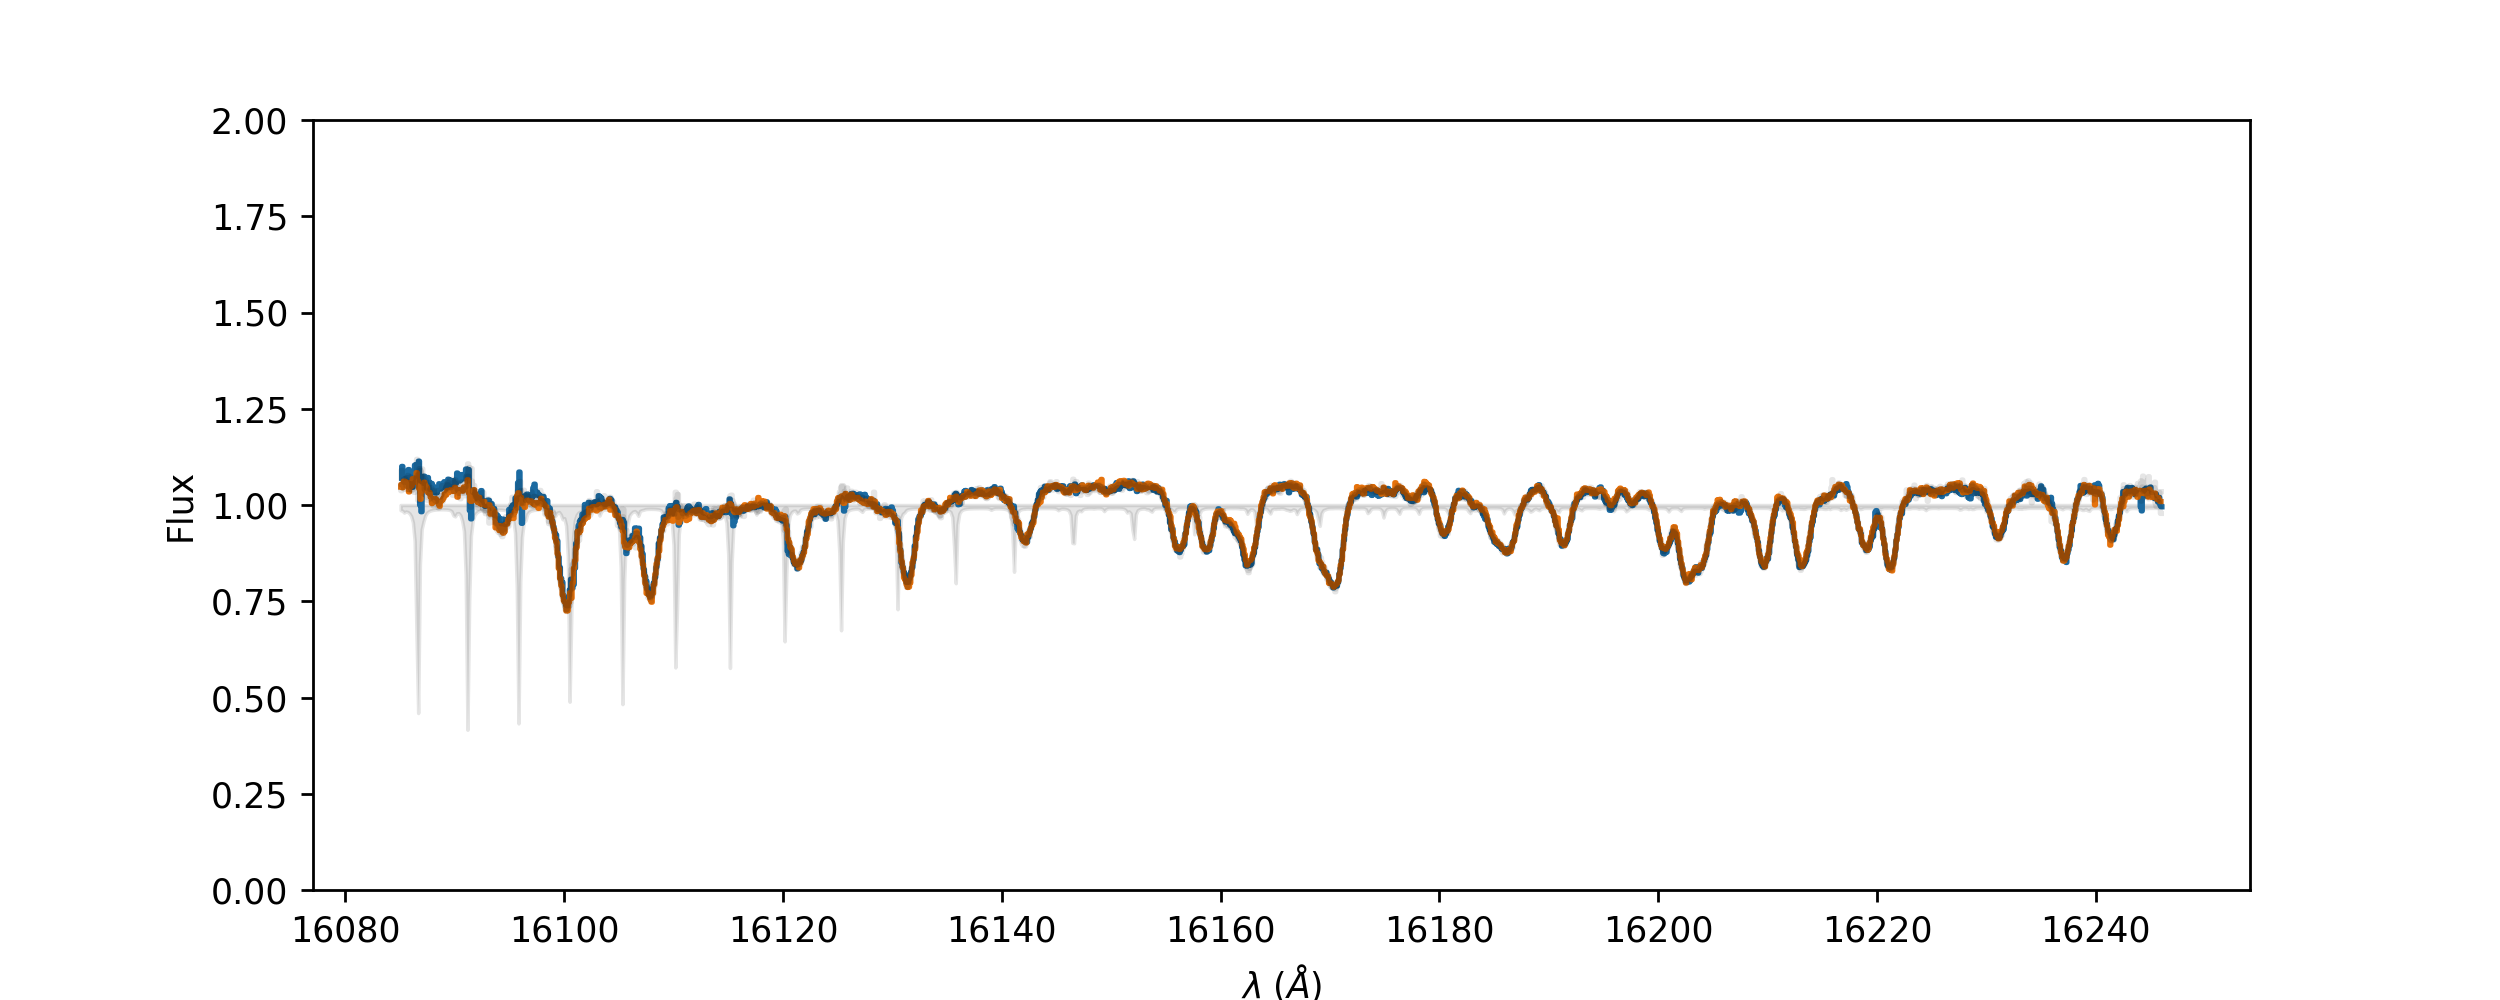

In [21]:
ax = spectra[0].trim_edges().normalize().barycentric_correct().plot(ylo=0, yhi=2)
spectra[4].trim_edges().normalize().barycentric_correct().plot(ax=ax)
for spectrum in spectra:
    spec = spectrum.trim_edges().remove_nans().normalize().barycentric_correct()
    ax.step(spec.wavelength, spec.flux, color='k', alpha=0.1)
    
plt.fill_between(tell_spec.wavelength, tell_spec.flux, 1, color='k', alpha=0.1, label='Telluric')

In [22]:
grid = PHOENIXGrid(teff_range=(4800, 6200), metallicity_range=(-0.5, 0.5), wl_lo=wl_lo, wl_hi=wl_hi)

Processing Teff=6200 K, logg=6.00, Z=+0.5: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


In [23]:
grid.show_dashboard(data=data)

Neat! We have a decent system!  We need to add some more HPF-specific post-processing to the `muler` toolkit.